<a href="https://colab.research.google.com/github/victorm0202/curso_ML_metagenomica/blob/main/notebooks/nnet_otus_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural networks on OTUS data

In [4]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
os.chdir('/content/drive/My Drive/Cursos/metagenomica/Notebooks/')
!pwd

/content/drive/My Drive/Cursos/metagenomica/Notebooks


In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

otus = pd.read_csv("../data/OTUS_conservados.csv", index_col="X")

cont_names = list(otus.drop(["New_Labels","Latitude", "Longitude"], axis=1).columns)
y_names = ["New_Labels"]
otus_df = otus[cont_names+y_names]

In [7]:
def get_reduced_data(data,y_counts,ylab='New_Labels',n_min=20):
    y_val = y_counts[y_counts>n_min]
    data_val_df = data.loc[data[ylab].isin(y_val.index)]
    return data_val_df, y_val

In [8]:
y_counts = otus_df.New_Labels.value_counts()
y_counts

Snow-FullH-HotSum2        709
Snow-FullH-CoolSum8       321
WarmT-FullH-HotSum3       309
WarmT-FullH-HotSum2       284
Snow-WintDry-CoolSum7     228
Equat-FullH5              130
WarmT-FullH-HotSum6       126
WarmT-SumDry-WarmSum0      71
WarmT-FullH-WarmSum4       71
Equat-WintDry4             69
Snow-FullH-CoolSum3        69
Equat-Monsoonal2           67
WarmT-FullH-WarmSum10      67
Equat-WintDry2             62
Equat-FullH1               55
Equat-Monsoonal4           43
Polar-PolarTundra8         41
Polar-PolarFrost9          31
WarmT-Dessert-WarmSum4     31
WarmT-FullH-WarmSum2       28
Snow-FullH-WarmSum2        25
WarmT-FullH-WarmSum6       23
Arid-Steppe-HotArid4       23
Polar-PolarTundra10        22
Snow-WintDry-WarmSum3      22
Snow-FullH-CoolSum0        21
Snow-FullH-WarmSum0        20
Arid-Steppe-ColdArid0      12
Equat-FullH4               11
Polar-PolarFrost6          11
WarmT-SumDry-HotSum0        8
Arid-Dessert-ColdArid0      7
Arid-Dessert-HotArid0       5
Equat-Full

In [9]:
n_min = 25
otus_reduced_df, y_reduced = get_reduced_data(otus_df,y_counts,'New_Labels',n_min)
otus_reduced_df.shape

(2812, 604)

## Batch samples and data loaders

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data.dataset import random_split
%matplotlib inline
#plt.style.use('seaborn') 

yy = np.array(otus_reduced_df[y_names]).ravel()
X_numpy = np.array(otus_reduced_df.drop(y_names,axis=1)).astype('float')

le = preprocessing.LabelEncoder()
le.fit(yy)
#le.classes_
y_numpy = le.transform(yy)
#le.inverse_transform(y_cat[:5])

In [11]:
from sklearn.utils.class_weight import compute_class_weight

def split_stratified_into_train_val_test(X, y, frac_train=0.6, frac_val=0.15, frac_test=0.25,
                                         random_state=None):
    '''
    Splits a dataset into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in y (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    X : numpy dataframe of covariates
    y : numpy array of responses
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''
    
    if round(frac_train + frac_val + frac_test,10) != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    # Split original dataframe into temp and test dataframes.
    #x_train, x_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state)
    x_temp, x_test, y_temp, y_test = train_test_split(X, y, stratify=y, test_size=(1.0 - (frac_train+frac_val)), random_state=random_state)
    # standardize train_val (temp) and test data
    scaler = StandardScaler()
    x_temp = scaler.fit_transform(x_temp)
    x_test = scaler.transform(x_test)
    # weights for class imbalance (https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html)
    class_w = compute_class_weight('balanced',classes=np.unique(y_temp),y=y_temp)
    # the latter is equivalent to:
    # unique, class_counts = np.unique(y_temp, return_counts=True)
    # class_w = sum(class_counts)/(len(unique)*class_counts)

    # Split the temp dataframe into train and val dataframes.
    #relative_frac_test = frac_test / (frac_val + frac_test)
    #x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, stratify=y_temp, test_size=relative_frac_test, random_state=random_state)
    relative_frac_val = frac_val / (frac_train + frac_val)
    x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, stratify=y_temp, test_size=relative_frac_val, random_state=random_state)

    #assert len(df_input) == len(df_train) + len(df_val) + len(df_test)
    return x_train, y_train, x_val, y_val, x_test, y_test, class_w, scaler

In [19]:
# create train (70%), validation (20%) and test (10%) datasets
X_tr, y_tr, X_val, y_val, X_te, y_te, class_w, __ = split_stratified_into_train_val_test(X_numpy, y_numpy, .70, .20, .10)

Class weights

In [20]:
tt = pd.DataFrame({'counts':np.bincount(y_numpy),'class_weight':class_w},index=le.inverse_transform(np.unique(y_tr)))
tt.sort_values('counts')

,counts,class_weight
WarmT-FullH-WarmSum2,28,5.060000
Polar-PolarFrost9,31,4.517857
WarmT-Dessert-WarmSum4,31,4.517857
Polar-PolarTundra8,41,3.418919
Equat-Monsoonal4,43,3.243590
Equat-FullH1,55,2.581633
Equat-WintDry2,62,2.258929
Equat-Monsoonal2,67,2.108333
WarmT-FullH-WarmSum10,67,2.108333
Equat-WintDry4,69,2.040323


In [17]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [21]:
# Turn data into tensors
X_train = torch.from_numpy(X_tr).type(torch.float)
y_train = torch.from_numpy(y_tr).type(torch.LongTensor)
X_val = torch.from_numpy(X_val).type(torch.float)
y_val = torch.from_numpy(y_val).type(torch.LongTensor)
X_test = torch.from_numpy(X_te).type(torch.float)
y_test = torch.from_numpy(y_te).type(torch.LongTensor)
class_weights = torch.tensor(class_w,dtype=torch.float)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
class_weights = class_weights.to(device)

In [24]:
class nnet_otus(nn.Module):
    def __init__(self, input_features, output_features):
        super(nnet_otus, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=520), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=520, out_features=520), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=520, out_features=300), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=300, out_features=100), 
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=output_features), 
        )

    def forward(self, x):
        return self.seq(x)


In [25]:
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)

batch_size = 32
# Builds a loader for each dataset to perform mini-batch gradient descent
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

In [26]:
# Set the hyperparameters for data creation
NUM_CLASSES = len(le.classes_)
NUM_FEATURES = X_train.shape[1]

# Create an instance of the model and send it to target device
model = nnet_otus(NUM_FEATURES, NUM_CLASSES).to(device)

# Setup loss and optimizer 
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0) 

# Fit the model
torch.manual_seed(42)
epochs = 100

# Build training and evaluation loop
for epoch in range(epochs):  
    ### Training
    model.train()
    for x_batch, y_batch in train_loader:
      
      # 1. Forward pass (model outputs raw logits)
      y_logits = model(x_batch) # model outputs raw logits 
      y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

      # 2. Calculate loss/accuracy
      loss = loss_fn(y_logits, y_batch) 
      acc = accuracy_score(y_batch.detach().cpu().numpy(), y_pred.detach().cpu().numpy()) 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backwards
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # Uses loader to fetch one mini-batch for validation
      for x_batch, y_batch in val_loader:
          # 1. Forward pass
          test_logits = model(x_batch)
          test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
          # 2. Caculate loss/accuracy
          test_loss = loss_fn(test_logits, y_batch)
          test_acc = accuracy_score(y_batch.detach().cpu().numpy(), test_pred.detach().cpu().numpy())

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation loss: {test_loss:.5f}, Validation acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 2.85375, Accuracy: 0.07% | Validation loss: 2.76627, Validation acc: 0.05%
Epoch: 10 | Loss: 0.00490, Accuracy: 1.00% | Validation loss: 0.02790, Validation acc: 1.00%
Epoch: 20 | Loss: 0.00014, Accuracy: 1.00% | Validation loss: 0.17823, Validation acc: 0.95%
Epoch: 30 | Loss: 0.00009, Accuracy: 1.00% | Validation loss: 0.01882, Validation acc: 1.00%
Epoch: 40 | Loss: 0.00009, Accuracy: 1.00% | Validation loss: 0.10036, Validation acc: 0.95%
Epoch: 50 | Loss: 0.00002, Accuracy: 1.00% | Validation loss: 0.25693, Validation acc: 0.95%
Epoch: 60 | Loss: 0.00019, Accuracy: 1.00% | Validation loss: 0.17480, Validation acc: 0.95%
Epoch: 70 | Loss: 0.00005, Accuracy: 1.00% | Validation loss: 0.17508, Validation acc: 0.95%
Epoch: 80 | Loss: 0.00004, Accuracy: 1.00% | Validation loss: 0.15951, Validation acc: 0.95%
Epoch: 90 | Loss: 0.00006, Accuracy: 1.00% | Validation loss: 0.18287, Validation acc: 0.95%


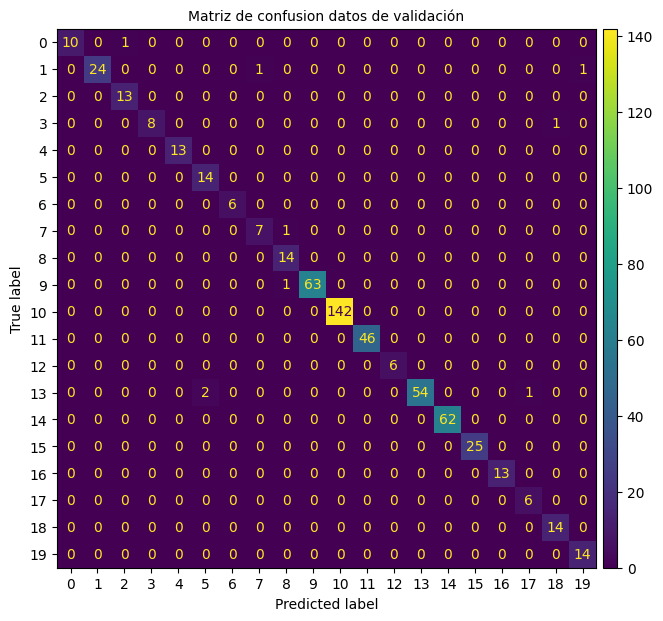

In [31]:
model.eval()
with torch.no_grad():
  val_logits = model(X_val)
  y_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)

plt.style.use('default') 
cm = metrics.confusion_matrix(y_val.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), normalize=None)
disp1 = metrics.ConfusionMatrixDisplay(cm, display_labels=np.arange(len(le.classes_)))
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Matriz de confusion datos de validación',{'fontsize':10})

disp1.plot(ax=ax, colorbar=False)
# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(disp1.im_,  cax=cax);

In [32]:
print(metrics.classification_report(y_val.detach().cpu().numpy(), y_pred.detach().cpu().numpy()))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       1.00      0.92      0.96        26
           2       0.93      1.00      0.96        13
           3       1.00      0.89      0.94         9
           4       1.00      1.00      1.00        13
           5       0.88      1.00      0.93        14
           6       1.00      1.00      1.00         6
           7       0.88      0.88      0.88         8
           8       0.88      1.00      0.93        14
           9       1.00      0.98      0.99        64
          10       1.00      1.00      1.00       142
          11       1.00      1.00      1.00        46
          12       1.00      1.00      1.00         6
          13       1.00      0.95      0.97        57
          14       1.00      1.00      1.00        62
          15       1.00      1.00      1.00        25
          16       1.00      1.00      1.00        13
          17       0.86    

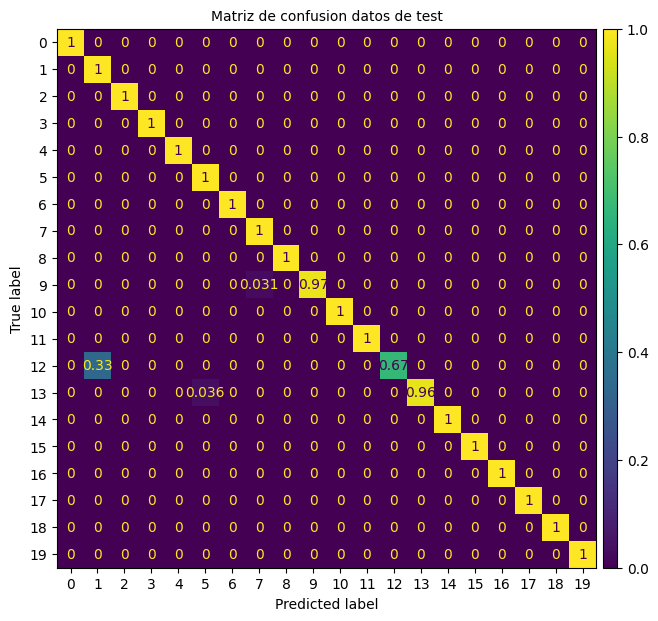

In [33]:
model.eval()
with torch.no_grad():
  val_logits = model(X_test)
  y_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)

plt.style.use('default') 
cm = metrics.confusion_matrix(y_test.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), normalize='true')
disp1 = metrics.ConfusionMatrixDisplay(cm, display_labels=np.arange(len(le.classes_)))
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Matriz de confusion datos de test',{'fontsize':10})

disp1.plot(ax=ax, colorbar=False)
# Adding custom colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(disp1.im_,  cax=cax);

In [34]:
print(metrics.classification_report(y_test.detach().cpu().numpy(), y_pred.detach().cpu().numpy()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.93      1.00      0.96        13
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         6
           5       0.88      1.00      0.93         7
           6       1.00      1.00      1.00         3
           7       0.80      1.00      0.89         4
           8       1.00      1.00      1.00         7
           9       1.00      0.97      0.98        32
          10       1.00      1.00      1.00        71
          11       1.00      1.00      1.00        23
          12       1.00      0.67      0.80         3
          13       1.00      0.96      0.98        28
          14       1.00      1.00      1.00        31
          15       1.00      1.00      1.00        13
          16       1.00      1.00      1.00         7
          17       1.00    

## Neural networks as feature extractor

In [42]:
global view_output
def hook_fn(module, input, output):
    global view_output
    view_output = output
net = nnet_otus(NUM_FEATURES, NUM_CLASSES).to(device)
hook = net.seq[-3].register_forward_hook(hook_fn)

with torch.no_grad():
  val_logits = net(X_train)


In [43]:
hidden_data = view_output.detach().cpu().numpy()
hidden_data.shape

(1967, 100)

A visualization of the last hidden layer

In [45]:
from sklearn.decomposition import PCA
import plotly.express as px

y_tr = y_train.detach().cpu().numpy()

ncomp=3
pca=PCA(ncomp)
hidden_pca = pca.fit_transform(hidden_data)
proj = pd.DataFrame(hidden_pca,columns = ['pc1','pc2','pc3'])
pca_proj = pd.DataFrame({'pc1': proj['pc1'], 'pc2': proj['pc2'], 'clima': y_tr})

In [46]:
fig = px.scatter(pca_proj, x='pc1', y='pc2', hover_data=['clima'], color = 'clima')
fig.update_layout(autosize=False,width=800,height=800,)
fig.show()

In [47]:
with torch.no_grad():
  val_logits = net(X_test)
hidden_test = view_output.detach().cpu().numpy()
y_te = y_test.detach().cpu().numpy()

hidden_test.shape

(282, 100)

In [48]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=1.5, gamma=1.7)
svm.fit(hidden_data, y_tr)
y_hat = svm.predict(hidden_test)

In [49]:
print(metrics.classification_report(y_te, y_hat))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.50      0.46      0.48        13
           2       1.00      0.71      0.83         7
           3       1.00      0.50      0.67         4
           4       0.86      1.00      0.92         6
           5       0.50      0.14      0.22         7
           6       0.00      0.00      0.00         3
           7       1.00      0.50      0.67         4
           8       0.50      0.14      0.22         7
           9       0.54      0.84      0.66        32
          10       0.84      0.99      0.91        71
          11       0.72      0.78      0.75        23
          12       0.00      0.00      0.00         3
          13       0.65      0.93      0.76        28
          14       0.97      1.00      0.98        31
          15       0.78      0.54      0.64        13
          16       0.50      0.14      0.22         7
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [50]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

best_score = 0
scores_mean = []
scores_sd = []
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        #print('gamma: ',gamma, '. C:', C)
        # for each combination of parameters,
        # train an SVM
        svm = SVC(kernel = 'rbf', gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, hidden_data, y_tr, cv=10)
        scores_mean.append(scores.mean())
        scores_sd.append(scores.std() * 2)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:            
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(hidden_data, y_tr)

SVC(C=10, gamma=1)

In [51]:
y_hat = svm.predict(hidden_test)
print(metrics.classification_report(y_te, y_hat))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.29      0.46      0.35        13
           2       0.83      0.71      0.77         7
           3       0.67      0.50      0.57         4
           4       0.86      1.00      0.92         6
           5       0.50      0.14      0.22         7
           6       0.00      0.00      0.00         3
           7       1.00      0.75      0.86         4
           8       0.40      0.29      0.33         7
           9       0.65      0.75      0.70        32
          10       0.88      0.99      0.93        71
          11       0.69      0.78      0.73        23
          12       1.00      0.33      0.50         3
          13       0.68      0.75      0.71        28
          14       0.94      0.94      0.94        31
          15       0.64      0.54      0.58        13
          16       0.00      0.00      0.00         7
          17       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
hook.remove()